<h2>CS 4780/5780 Final Project: </h2>
<h3>Election Result Prediction for US Counties</h3>

Jerry Sun, Peter Wu, Shihao Cao (js2746, plw53, sfc72)

<h3>Introduction:</h3>

<p> The final project is about conducting a real-world machine learning project on your own, with everything that is involved. Unlike in the programming projects 1-5, where we gave you all the scaffolding and you just filled in the blanks, you now start from scratch. The programming project provide templates for how to do this, and the most recent video lectures summarize some of the tricks you will need (e.g. feature normalization, feature construction). So, this final project brings realism to how you will use machine learning in the real world.  </p>

The task you will work on is forecasting election results. Economic and sociological factors have been widely used when making predictions on the voting results of US elections. Economic and sociological factors vary a lot among counties in the United States. In addition, as you may observe from the election map of recent elections, neighbor counties show similar patterns in terms of the voting results. In this project you will bring the power of machine learning to make predictions for the county-level election results using Economic and sociological factors and the geographic structure of US counties. </p>
<p>

<h3>Your Task:</h3>
Plase read the project description PDF file carefully and make sure you write your code and answers to all the questions in this Jupyter Notebook. Your answers to the questions are a large portion of your grade for this final project. Please import the packages in this notebook and cite any references you used as mentioned in the project description. You need to print this entire Jupyter Notebook as a PDF file and submit to Gradescope and also submit the ipynb runnable version to Canvas for us to run.

<h3>Due Date:</h3>
The final project dataset and template jupyter notebook will be due on <strong>December 15th</strong> . Note that <strong>no late submissions will be accepted</strong>  and you cannot use any of your unused slip days before.
</p>

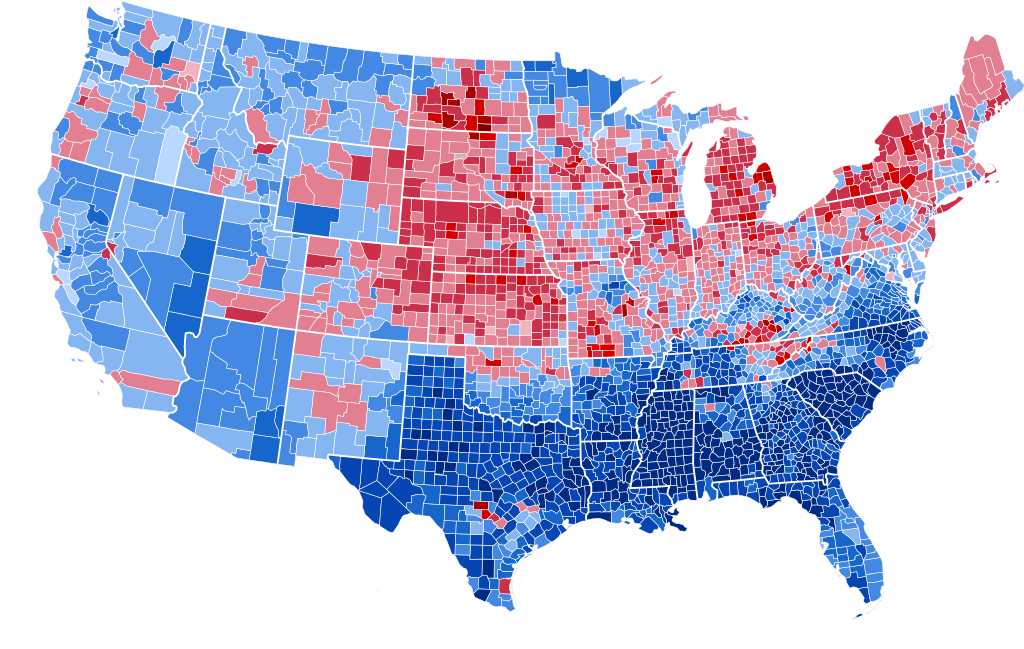

<h2>Part 1: Basics</h2><p>

<h3>1.1 Import:</h3><p>
Please import necessary packages to use. Note that learning and using packages are recommended but not required for this project. Some official tutorial for suggested packacges includes:
    
https://scikit-learn.org/stable/tutorial/basic/tutorial.html
    
https://pytorch.org/tutorials/
    
https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html
<p>

In [22]:
import os
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier # Import KNN model for first basic solution
from sklearn import svm # Import SVM since it's good at predicting binary labels - second basic solution
from sklearn.model_selection import cross_val_score # uses K-fold cross-val by default.
from sklearn.metrics import make_scorer # Import scorer for use in cross-validation scoring (weighted accuracy)
import warnings
warnings.filterwarnings('ignore')

<h3>1.2 Weighted Accuracy:</h3><p>
Since our dataset labels are heavily biased, you need to use the following function to compute weighted accuracy throughout your training and validation process and we use this for testing on Kaggle.
<p>

In [ ]:
def weighted_accuracy(pred, true):
    assert(len(pred) == len(true))
    num_labels = len(true)
    num_pos = sum(true)
    num_neg = num_labels - num_pos
    frac_pos = num_pos/num_labels
    weight_pos = 1/frac_pos
    weight_neg = 1/(1-frac_pos)
    num_pos_correct = 0
    num_neg_correct = 0
    for pred_i, true_i in zip(pred, true):
        num_pos_correct += (pred_i == true_i and true_i == 1)
        num_neg_correct += (pred_i == true_i and true_i == 0)
    
    d_err = num_pos - num_pos_correct
    r_err = num_neg - num_neg_correct
    weighted_accuracy = ((weight_pos * num_pos_correct) 
                         + (weight_neg * num_neg_correct))/((weight_pos * num_pos) + (weight_neg * num_neg))
    return weighted_accuracy

<h2>Part 2: Baseline Solution</h2><p>
Note that your code should be commented well and in part 2.4 you can refer to your comments. (e.g. Here is SVM, 
Here is validation for SVM, etc). Also, we recommend that you do not to use 2012 dataset and the graph dataset to reach the baseline accuracy for 68% in this part, a basic solution with only 2016 dataset and reasonable model selection will be enough, it will be great if you explore thee graph and possibly 2012 dataset in Part 3.

<h3>2.1 Preprocessing and Feature Extraction:</h3><p>
Given the training dataset and graph information, you need to correctly preprocess the dataset (e.g. feature normalization). For baseline solution in this part, you might not need to introduce extra features to reach the baseline test accuracy.
<p>

In [ ]:
def preprocess(df):    
    # Binary Indicator of Dem or Gop winner of a county
    df['Winner'] = 0
    for x in range(0, len(df)):    
        if df['DEM'][x] > df['GOP'][x]:
            df['Winner'][x] = 1
        else:
            df['Winner'][x] = 0

    norm_cols = ['MedianIncome','MigraRate', 'BirthRate', 'DeathRate', 'BachelorRate', 'UnemploymentRate']
    for col in norm_cols:
        factor = max(df[col])
        df[col] = df[col]/factor
    return df

def test_preprocess(df):
    #Standardization normalization
    norm_cols = ['MedianIncome','MigraRate', 'BirthRate', 'DeathRate', 'BachelorRate', 'UnemploymentRate']
    for col in norm_cols:
        factor = max(df[col])
        df[col] = df[col]/factor
    return df

def package(preds, df):
    df['Result'][0:] = preds.astype(int)
    return df

In [ ]:
rawdf16 = pd.read_csv('train_2016.csv', sep=',', thousands=',',encoding='unicode_escape')
df16 = preprocess(rawdf16.copy())
df16


In [ ]:
rawdf12 = pd.read_csv('train_2012.csv', sep=',', thousands=',',encoding='unicode_escape')
df12 = preprocess(rawdf12.copy())
df12


In [ ]:
dfgraph = pd.read_csv('graph.csv', sep=',', encoding='unicode_escape')
dfgraph


In [28]:
dfsample = pd.read_csv('sampleSubmission.csv', sep=',', encoding='unicode_escape')
dfsample

,FIPS,Result
0,17059,0
1,6103,0
2,42047,0
3,47147,0
4,39039,0
...,...,...
1550,55095,0
1551,34035,0
1552,42107,0
1553,48293,0


In [29]:
rawtest16 = pd.read_csv('test_2016_no_label.csv', sep=',', thousands=",", encoding='unicode_escape')
test16 = test_preprocess(rawtest16.copy())
test16


,FIPS,County,MedianIncome,MigraRate,BirthRate,DeathRate,BachelorRate,UnemploymentRate
0,17059,"Gallatin County, IL",0.335782,-0.050548,0.378947,0.363372,0.126115,0.381910
1,6103,"Tehama County, CA",0.343839,0.008584,0.449123,0.302326,0.197452,0.356784
2,42047,"Elk County, PA",0.417452,-0.044349,0.340351,0.377907,0.236943,0.276382
3,47147,"Robertson County, TN",0.495506,0.035289,0.445614,0.281977,0.236943,0.206030
4,39039,"Defiance County, OH",0.442326,-0.025274,0.389474,0.296512,0.212739,0.246231
...,...,...,...,...,...,...,...,...
1550,55095,"Polk County, WI",0.454619,0.006676,0.333333,0.313953,0.259873,0.231156
1551,34035,"Somerset County, NJ",0.886754,-0.009061,0.354386,0.209302,0.694268,0.206030
1552,42107,"Schuylkill County, PA",0.426136,-0.000477,0.326316,0.389535,0.206369,0.311558
1553,48293,"Limestone County, TX",0.333647,0.002384,0.463158,0.328488,0.178344,0.281407


In [30]:
rawtest12 = pd.read_csv('test_2012_no_label.csv', sep=',', thousands=",", encoding='unicode_escape')
test12 = test_preprocess(rawtest12.copy())
test12

,FIPS,County,MedianIncome,MigraRate,BirthRate,DeathRate,BachelorRate,UnemploymentRate
0,17059,"Gallatin County, IL",0.314441,-0.128660,0.299003,0.570796,0.142477,0.351464
1,6103,"Tehama County, CA",0.318161,-0.031056,0.378738,0.420354,0.187750,0.573222
2,42047,"Elk County, PA",0.401674,-0.026619,0.322259,0.548673,0.205060,0.292887
3,47147,"Robertson County, TN",0.445897,-0.039929,0.475083,0.415929,0.225033,0.292887
4,39039,"Defiance County, OH",0.382532,-0.057675,0.385382,0.433628,0.217044,0.322176
...,...,...,...,...,...,...,...,...
1550,55095,"Polk County, WI",0.412586,-0.099379,0.318937,0.371681,0.255659,0.334728
1551,34035,"Somerset County, NJ",0.788239,0.000000,0.345515,0.300885,0.692410,0.309623
1552,42107,"Schuylkill County, PA",0.366433,0.007098,0.328904,0.584071,0.198402,0.405858
1553,48293,"Limestone County, TX",0.300998,0.011535,0.451827,0.469027,0.181092,0.288703


<h3>2.2 Use At Least Two Training Algorithms from class:</h3><p>
You need to use at least two training algorithms from class. You can use your code from previous projects or any packages you imported in part 1.1.

In [31]:
# Basic Model 1 - K-Nearest Neighbors

def knn_classifier(k_grid, distance_metrics, train_x, train_y):
    '''Returns KNN parameters for classifying county election results.

    Args: 
      k_grid: interval for grid searching number of neighbors
      distance_metrics: array of distance metric strings for the K-nearest neighbor classifier
      train_x: feature vectors for each county in training set
      train_y: labels for each county in training set
    Returns: 
      array of length 3 containing best accuracy and values of C and gamma that gave that accuracy.
    '''
    # Initialize best array to store our best calculated hyperparameters as well as the best accuracy so far.
    best = [0, 0, 'euclidean']
    # Create sklearn scorer based on the weighted accuracy function given
    scorer = make_scorer(weighted_accuracy)
    
    # Grid search with cross-validation
    for metric in distance_metrics:
        for k in k_grid:
            knn_model = KNeighborsClassifier(n_neighbors=k, metric=metric)
            scores = cross_val_score(knn_model, train_x, train_y, cv=10, scoring=scorer)
            # Cache this specific model with its hyperparameters if the weighted accuracy is best.
            if np.mean(scores) > best[0]:
                    best[0], best[1], best[2] = np.mean(scores), k, metric
    return best


In [32]:
# Basic Model 2 - SVM with RBF Kernel 
def train_SVM(c_grid, g_grid, train_x, train_y):
    '''Trains an SVM using scikit-learn by conducting a grid search and cross-validation
       to find optimal hyperparameter values based on given intervals.
       
    Args: 
      c_grid: interval for grid searching C values
      g_grid: interval for grid searching gamma values
      train_x: feature vectors for each county in training set
      train_y: labels for each county in training set
    Returns: 
      array of length 3 containing best accuracy and values of C and gamma that gave that accuracy.
    '''
    
    # Create sklearn scorer based on the weighted accuracy function given
    scorer = make_scorer(weighted_accuracy)
    # Initialize best array to store our best calculated hyperparameters as well as the best accuracy so far.
    best = [0, -1, -1]
    # Grid search with cross-validation.
    for c in c_grid:
        for g in g_grid:
            # We suspect the data to be nonlinear and RBF is a consistent choice for this purpose.
            svm_model = svm.SVC(kernel='rbf', C=c, gamma=g)
            scores = cross_val_score(svm_model, train_x, train_y, cv=10, scoring=scorer)
            # Cache this specific model with its hyperparameters if the weighted accuracy is best.
            if np.mean(scores) > best[0]:
                best[0], best[1], best[2] = np.mean(scores), c, g
    return best

<h3>2.3 Training, Validation and Model Selection:</h3><p>
You need to split your data to a training set and validation set or performing a cross-validation for model selection.

In [33]:
# Partition data into train for features and labels, and test labels for predictions
train_x = np.array(df16.iloc[0:,4:10])
train_y = np.array(df16.iloc[0:,10])
test_x = np.array(test16.iloc[0:,2:])

In [43]:
# K-Nearest Neighbors algorithm

# Grid search using these grids in the KNN model. For use with cross-validation.
ks = range(1, 6, 1)
distance_metrics = ['minkowski', 'manhattan', 'chebyshev', 'euclidean', 'seuclidean']

# Cross-validate on hyperparameters for model selection
best = knn_classifier(ks, distance_metrics, train_x, train_y)

print(best)
knn_model = KNeighborsClassifier(n_neighbors=best[1], metric=best[2])
knn_model.fit(train_x, train_y)
preds_knn = knn_model.predict(test_x)

[0.8294589416858154, 2, 'minkowski']


In [44]:
# SVM algorithm with 10-fold cross validation + grid search to find good hyperparameters.

# Grid search using these intervals for C and gamma in the SVM model. For use with cross-validation.
cs = (2.0**np.linspace(5,11,10))
gammas = (np.linspace(0.5,7,10))

# Cross-validate on hyperparameters for model selection
best = train_SVM(cs, gammas, train_x, train_y)

print(best)
svm_model = svm.SVC(kernel='rbf', C=best[1], gamma=best[2])
svm_model.fit(train_x, train_y)
preds_svm = svm_model.predict(test_x)

[0.8541057735917128, 128.0, 2.6666666666666665]


In [47]:
# Package predictions for both basic models into a csv for submission

submission_knn = package(preds_knn, dfsample.copy())
submission_svm = package(preds_svm, dfsample.copy())

submission_knn.to_csv('submission_knn.csv',index = False)
submission_svm.to_csv('submission_svm.csv',index = False)
submiss_knn = pd.read_csv('submission_knn.csv', sep=',', encoding='unicode_escape')
submiss_svm = pd.read_csv('submission_svm.csv', sep=',', encoding='unicode_escape')

<h3>2.4 Explanation in Words:</h3><p>
    You need to answer the following questions in the markdown cell after this cell:

2.4.1 How did you preprocess the dataset and features?

2.4.2 Which two learning methods from class did you choose and why did you made the choices?

2.4.3 How did you do the model selection?

2.4.4 Does the test performance reach a given baseline 68% performance? (Please include a screenshot of Kaggle Submission)

Yes. Here is a screenshot of both our submission scores for KNN and SVM solutions (both >68% performance)

![kaggle_basic_screenshot](kaggle_submission_basic.png)

<h2>Part 3: Creative Solution</h2><p>

<h3>3.1 Open-ended Code:</h3><p>
You may follow the steps in part 2 again but making innovative changes like creating new features, using new training algorithms, etc. Make sure you explain everything clearly in part 3.2. Note that reaching the 75% creative baseline is only a small portion of this part. Any creative ideas will receive most points as long as they are reasonable and clearly explained.

In [21]:
# Make sure you comment your code clearly and you may refer to these comments in the part 3.2
# Feature Engineering TODO: 
# graph data get % of neighbors voting D in 2012,
# Model TODO: regularization like https://medium.com/datadriveninvestor/a-simple-way-to-know-how-important-your-input-is-in-neural-network-86cbae0d3689 or/and https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/ 
# TODO 

### 3.1.1 Import Statements

In [48]:
import os
os.environ['TF_CPP_MIN_VLOG_LEVE'] = '3' # avoid printing INFO, WARNING, and ERROR msgs
import tensorflow as tf

import pandas as pd
import numpy as np
tf.random.set_seed(123)

from IPython.display import clear_output
from matplotlib import pyplot as plt


### 3.1.1.1 Import Statements Pre + Post Processing Setup


In [49]:
def gen_class_weights(df):
    df['Weight'] = 0.0
    # rationale: training data has roughly 5.9 ratio of GOP counties to DEM
    d_weight = 5.0 
    r_weight = 1.0
    # assign weights accordingly
    for x in range(0, len(df)):    
        if df['Winner'][x] == 1:
            df['Weight'][x] = d_weight
        else:
            df['Weight'][x] = r_weight
       
    return df

def gen_labels(df):
    # Binary Indicator of Dem or GOP winner of a county
    df['Winner'] = 0
    for x in range(0, len(df)):    
        if df['DEM'][x] > df['GOP'][x]:
            df['Winner'][x] = 1
        else:
            df['Winner'][x] = 0
       
    return df

def norm_preprocess(df):    
    #Standardization normalization
    norm_cols = ['MedianIncome','MigraRate', 'BirthRate', 'DeathRate', 'BachelorRate', 'UnemploymentRate']
    for col in norm_cols:
        factor = max(df[col])
        df[col] = df[col] / factor
    return df

def ratio_preprocess(df):    
    df['Winner'] = 0.0
    for x in range(0, len(df)):    
        d = float(df['DEM'][x])
        r = df['GOP'][x]
        total_pop = d + r
        mult = 1
        if d > r:
            mult = 1
        df['Winner'][x] =mult*d/total_pop
    return df

def cthresh(preds, thresh=0.5):
    preds = (preds > thresh).astype(int)
    return preds

def cpackage(preds, df, thresh = 0.5):
    df['Result'][0:] = (preds > thresh).astype(int)
    return df

### 3.1.1.2 Data Setup



In [50]:
# Read train/test data from given CSVs and preprocess the test data

rawdf16 = pd.read_csv('train_2016.csv', sep=',', thousands=',',encoding='unicode_escape')
df16 = gen_labels(rawdf16)

rawdf12 = pd.read_csv('train_2012.csv', sep=',', thousands=',',encoding='unicode_escape')
df12 = gen_labels(rawdf12)

dfgraph = pd.read_csv('graph.csv', sep=',', encoding='unicode_escape')

dfsample = pd.read_csv('sampleSubmission.csv', sep=',', encoding='unicode_escape')

rawtest16 = pd.read_csv('test_2016_no_label.csv', sep=',', thousands=",", encoding='unicode_escape')
test16 = test_preprocess(rawtest16)

rawtest12 = pd.read_csv('test_2012_no_label.csv', sep=',', thousands=",", encoding='unicode_escape')
test12 = test_preprocess(rawtest12)

### 3.1.2 Feature Engineering

In [53]:
def graph_process(d16, graph, result, result12):
    # Adds extra features to the dataframe based on the graph structure of counties
    # Graph DST sorted least to greatest, other neighbors < DST FIPS can occur but with that DST as SRC
    neigh_exist, neigh_vote, neigh_swing, neigh_pop = [], [], [], []
    for row in range(len(d16)):
        # get current neighbors of county by FIPS
        neighbors = np.array(dfgraph[dfgraph['SRC'] == d16['FIPS'][row]]['DST'][1:])
        neighbors = np.append(neighbors,np.array(dfgraph[dfgraph['DST'] == d16['FIPS'][row]]['SRC'][:-1]))
        prop, swing = [], []
        dem, gop = 0, 0
        for neigh in neighbors:
            if len(result[result['FIPS'] == neigh]) > 0:
                prop = np.append(prop, np.array(result[result['FIPS'] == neigh]['Winner']))
                swing = np.append(swing, np.array(np.abs(np.array(result[result['FIPS'] == neigh]['Winner'])[0] - np.array(result12[result12['FIPS'] == neigh]['Winner'])[0])))
                dem += np.array(result[result['FIPS'] == neigh]['DEM'])[0]
                gop += np.array(result[result['FIPS'] == neigh]['GOP'])[0]
        if len(prop) == 0:
            neigh_vote.append(0.5)
            neigh_exist.append(0)
            neigh_swing.append(0.5)
            neigh_pop.append(0.5)
        else:
            neigh_vote.append(np.mean(prop))
            neigh_exist.append(1)
            neigh_swing.append(np.mean(swing))
            neigh_pop.append(dem / (dem + gop))

    # add feature columns to training data
    d16['neigh_vote'] = np.array(neigh_vote)
    d16['neigh_exist'] = np.array(neigh_exist)
    d16['neigh_swing'] = np.array(neigh_swing)
    d16['neigh_pop'] = np.array(neigh_pop)
    return d16

In [17]:
def cpreprocess(d16, d12, graph, test=False, ratio = False):
    # Preprocess raw dataframes
    creative = norm_preprocess(d16.copy())    
    creative = graph_process(creative.copy(), graph.copy(), df16.copy(), df12.copy())
    # Set up the Hot Encode Categorical State Column for Tensorflow to do it for us :)
    states = []
    for row in range(len(creative)):
        states.append(creative['County'][row][-2:])
    creative['StateCode'] = np.array(states)
    # Incorporate 2012->2016 changes in data and Standard Normalize them
    norm_cols = ['MedianIncome','MigraRate', 'BirthRate', 'DeathRate', 'BachelorRate', 'UnemploymentRate']
    
    # GENERATE 2012 COLS
    for cols in norm_cols:
        delta = np.array(d12[cols])
        name = cols + '2012'
        factor = max(delta)
        creative[name] = delta/np.abs(factor)
    
    # GENERATE DIFF COLS
    for cols in norm_cols:
        delta = np.array(d16[cols]) - np.array(d12[cols])
        name = cols + 'Diff'
        factor = max(delta)
        creative[name] = delta/np.abs(factor)
                
    if not test:
        if ratio:
            creative = ratio_preprocess(creative)
        else:
            creative = gen_labels(creative)
            creative = creative.astype({'Winner': 'int64'})
        
        # GENERATE CLASS WEIGHTS
        creative = gen_class_weights(creative)
        
        # get a list of the columns
        col_list = list(creative.columns)
        w_idx = col_list.index('Winner')
        del col_list[w_idx]
        col_list.append('Winner')

        creative = creative.reindex(columns=col_list)
        print(creative.dtypes)
    return creative

traindf = cpreprocess(rawdf16, rawdf12, dfgraph, ratio = False)
testdf = cpreprocess(rawtest16, rawtest12, dfgraph, test = True)
traindf

FIPS                      int64
County                   object
DEM                       int64
GOP                       int64
MedianIncome            float64
MigraRate               float64
BirthRate               float64
DeathRate               float64
BachelorRate            float64
UnemploymentRate        float64
neigh_vote              float64
neigh_exist               int32
neigh_swing             float64
neigh_pop               float64
StateCode                object
MedianIncome2012        float64
MigraRate2012           float64
BirthRate2012           float64
DeathRate2012           float64
BachelorRate2012        float64
UnemploymentRate2012    float64
MedianIncomeDiff        float64
MigraRateDiff           float64
BirthRateDiff           float64
DeathRateDiff           float64
BachelorRateDiff        float64
UnemploymentRateDiff    float64
Weight                  float64
Winner                    int64
dtype: object


,FIPS,County,DEM,GOP,MedianIncome,MigraRate,BirthRate,DeathRate,BachelorRate,UnemploymentRate,...,BachelorRate2012,UnemploymentRate2012,MedianIncomeDiff,MigraRateDiff,BirthRateDiff,DeathRateDiff,BachelorRateDiff,UnemploymentRateDiff,Weight,Winner
0,18019,"Clark County, IN",18791,30012,0.385093,0.094595,0.439863,0.384615,0.280161,0.174274,...,0.273611,0.284672,0.116587,0.073282,-0.032967,0.110169,0.063492,-0.734694,1.0,0
1,6035,"Lassen County, CA",2026,6533,0.369908,-0.355212,0.316151,0.220280,0.160858,0.286307,...,0.179167,0.456204,0.100885,0.021374,0.021978,-0.144068,-0.047619,-1.142857,1.0,0
2,40081,"Lincoln County, OK",2423,10838,0.333663,-0.025097,0.391753,0.409091,0.202413,0.219917,...,0.181944,0.182482,0.033367,0.022901,0.010989,0.050847,0.105820,0.061224,1.0,0
3,31153,"Sarpy County, NE",27704,44649,0.552519,0.177606,0.487973,0.174825,0.537534,0.120332,...,0.508333,0.142336,0.272866,0.018321,-0.186813,0.008475,0.185185,-0.204082,1.0,0
4,28055,"Issaquena County, MS",395,298,0.200261,-0.247104,0.336770,0.185315,0.089812,0.580913,...,0.108333,0.642336,-0.084137,-0.229008,0.131868,-0.161017,-0.058201,-0.734694,5.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1550,36009,"Cattaraugus County, NY",8717,18668,0.343395,-0.067568,0.384880,0.377622,0.256032,0.248963,...,0.250000,0.339416,0.148384,0.061069,-0.054945,0.059322,0.058201,-0.673469,1.0,0
1551,55031,"Douglas County, WI",11342,9657,0.373972,-0.050193,0.336770,0.356643,0.321716,0.215768,...,0.304167,0.251825,0.295154,0.059542,-0.131868,0.093220,0.111111,-0.346939,5.0,1
1552,27065,"Kanabec County, MN",2327,5230,0.381453,0.030888,0.347079,0.363636,0.195710,0.269710,...,0.186111,0.328467,0.310464,0.248855,0.329670,0.186441,0.063492,-0.510204,1.0,0
1553,17139,"Moultrie County, IL",1476,4453,0.426769,-0.177606,0.443299,0.454545,0.261394,0.190871,...,0.215278,0.259124,0.287347,-0.152672,0.065934,0.093220,0.211640,-0.510204,1.0,0


### 3.1.3 Actual Code


In [52]:
print(tf.__version__)

df16 = traindf
test16 = testdf

df16.head()

label_idx = len(df16.columns) - 1
stop_idx = label_idx
train_x = df16.iloc[0:,4:stop_idx]
train_y = df16.iloc[0:,label_idx]
test_x = test16.iloc[0:,2:]

# split = 1555 # splitting idx
split = 1100

N,d = train_x.shape

dftrain = train_x.iloc[:split,:]
y_train = train_y.iloc[:split]
dfeval = train_x.iloc[split:,:]
y_eval = train_y.iloc[split:]

2.3.1


In [ ]:
# Constants for use in model
CATEGORICAL_COLUMNS = []
CATEGORICAL_COLUMNS = ['StateCode']
NUMERIC_COLUMNS = ['MedianIncome', 'MigraRate', 'BirthRate', 'DeathRate', 'BachelorRate', 'UnemploymentRate']
NUMERIC_COLUMNS = ['MedianIncome', 'MigraRate', 'BirthRate', 'DeathRate', 'BachelorRate', 'UnemploymentRate']

NUMERIC_COLUMNS_2012 = []
NUMERIC_COLUMNS_DIFF = []
NUMERIC_GRAPH_EXTEND = []

NUMERIC_COLUMNS_2012 = [x+'2012' for x in NUMERIC_COLUMNS]
NUMERIC_COLUMNS_DIFF = [x+'Diff' for x in NUMERIC_COLUMNS]

NUMERIC_GRAPH_EXTEND = ['neigh_vote', 'neigh_swing', 'neigh_pop']

NUMERIC_COLUMNS += NUMERIC_COLUMNS_2012
# NUMERIC_COLUMNS += NUMERIC_COLUMNS_DIFF
NUMERIC_COLUMNS += NUMERIC_GRAPH_EXTEND

REMOVE = ['MigraRate', 'MigraRate2012', 'BirthRate']
# REMOVE += ['UnemploymentRate2016','BirthRate2012']
NUMERIC_COLUMNS = [x for x in NUMERIC_COLUMNS if x not in REMOVE]

         0.084656   
934        0.215267      -0.362637       0.203390         -0.174603   
935       -0.505344      -0.153846       0.050847          0.010582   
936        0.312977      -0.175824      -0.042373         -0.148148   
937       -0.025954       0.109890      -0.033898         -0.015873   
...             ...            ...            ...               ...   
1239       0.042748      -0.043956       0.144068          0.074074   
1240      -0.800000      -0.285714       0.016949          0.195767   
1241       0.161832      -0.043956      -0.025424          0.116402   
1242      -0.250382       0.186813      -0.042373          0.359788   
1243       0.062595       0.131868      -0.016949          0.047619   

      UnemploymentRateDiff  Weight  
933               0.551020     1.0  
934              -0.387755     1.0  
935              -0.204082     1.0  
936              -0.183673     1.0  
937              -0.816327     1.0  
...                    ...     ...  
1239     

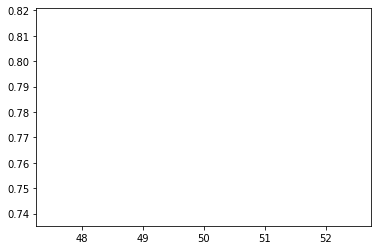

[ $$$ ] TEST
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False t

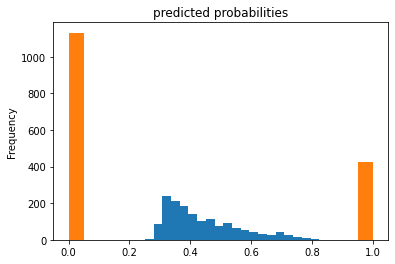

[ *** ] STEP MAX: 100
[ $$$ ] TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting b

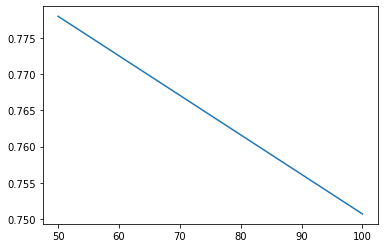

[ $$$ ] TEST
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False t

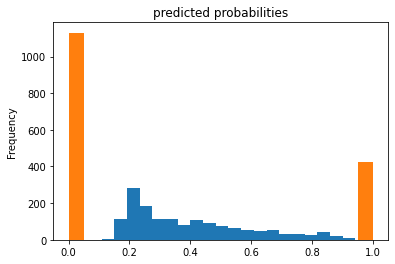

[ *** ] STEP MAX: 150
[ $$$ ] TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting b

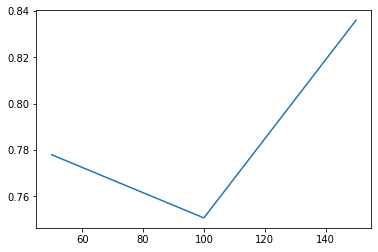

[ $$$ ] TEST
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False t

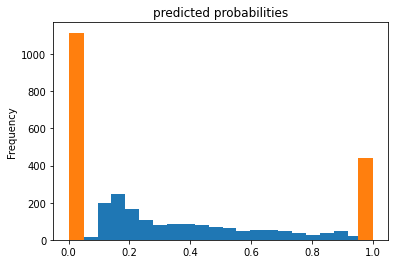

[ *** ] STEP MAX: 200
[ $$$ ] TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting b

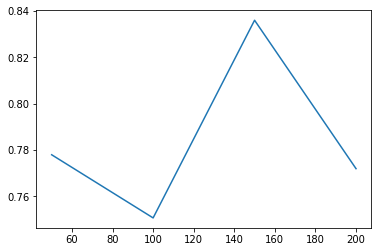

[ $$$ ] TEST
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False t

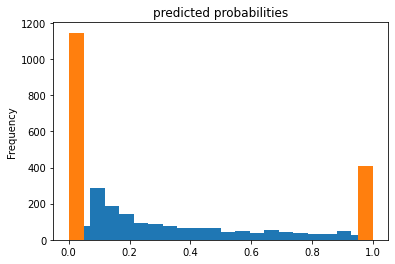

[ *** ] STEP MAX: 250
[ $$$ ] TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting b

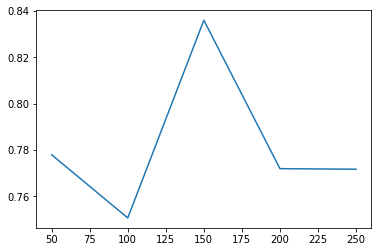

[ $$$ ] TEST
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False t

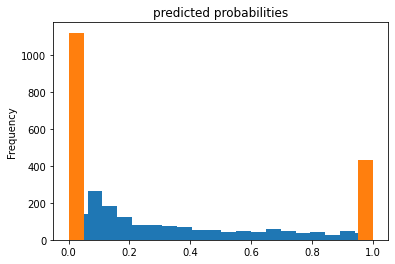

[ *** ] STEP MAX: 300
[ $$$ ] TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting b

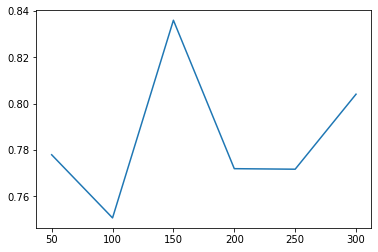

[ $$$ ] TEST
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False t

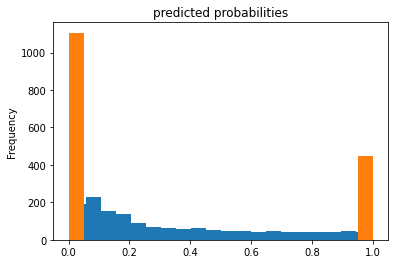

[ *** ] STEP MAX: 350
[ $$$ ] TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting b

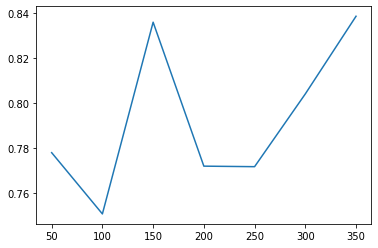

[ $$$ ] TEST
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False t

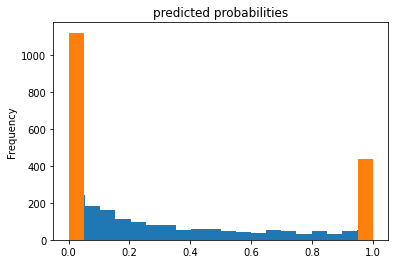

[ *** ] STEP MAX: 400
[ $$$ ] TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting b

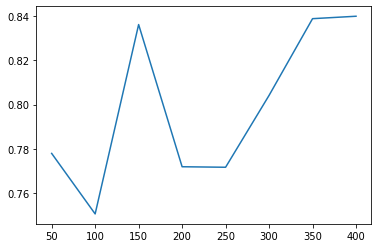

[ $$$ ] TEST
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False t

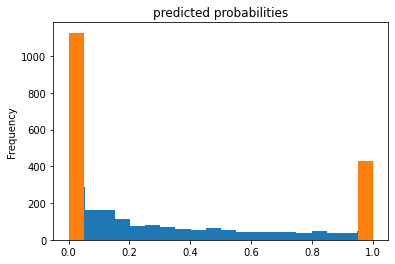

[ *** ] STEP MAX: 450
[ $$$ ] TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting b

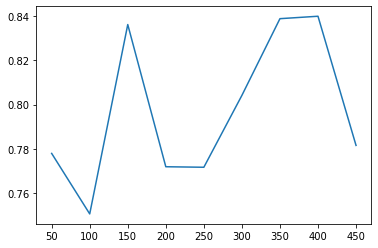

[ $$$ ] TEST
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False t

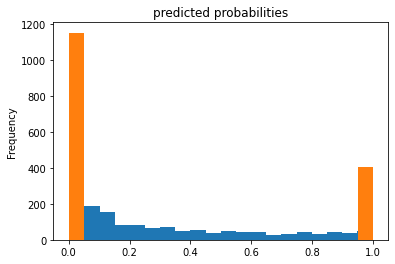

[ *** ] STEP MAX: 500
[ $$$ ] TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting b

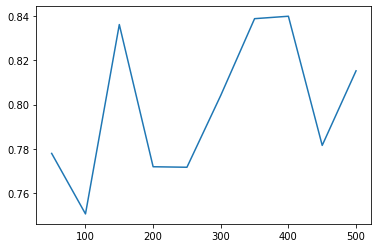

[ $$$ ] TEST
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False t

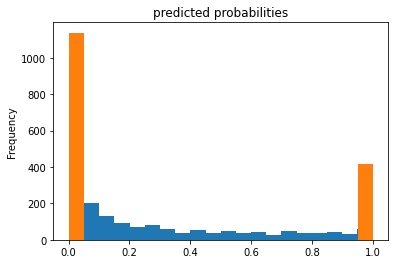

[ *** ] STEP MAX: 550
[ $$$ ] TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting b

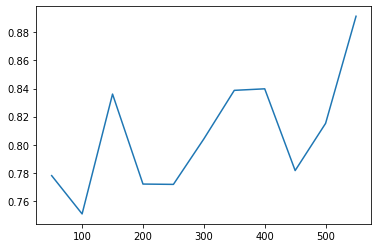

[ $$$ ] TEST
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False t

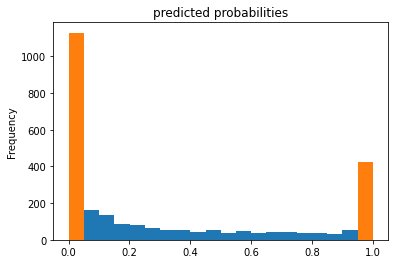

[ *** ] STEP MAX: 600
[ $$$ ] TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting b

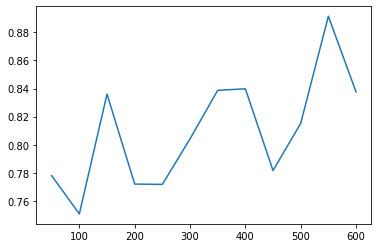

[ $$$ ] TEST
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False t

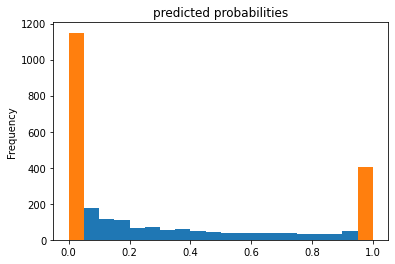

[ *** ] STEP MAX: 650
[ $$$ ] TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting b

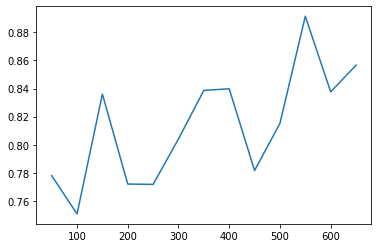

[ $$$ ] TEST
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False t

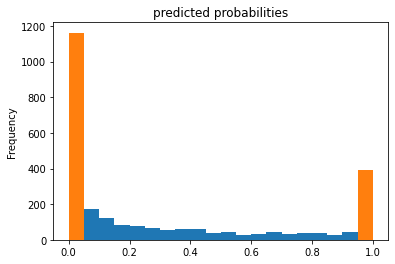

[ *** ] STEP MAX: 700
[ $$$ ] TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting b

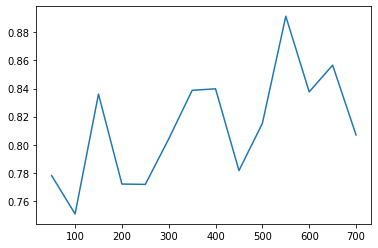

[ $$$ ] TEST
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False t

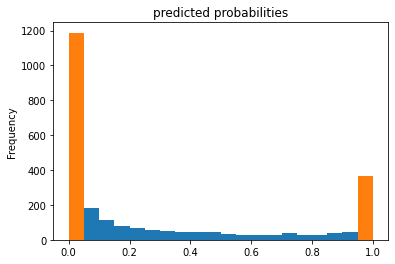

[ *** ] STEP MAX: 750
[ $$$ ] TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting b

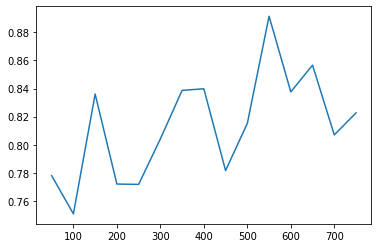

[ $$$ ] TEST
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False t

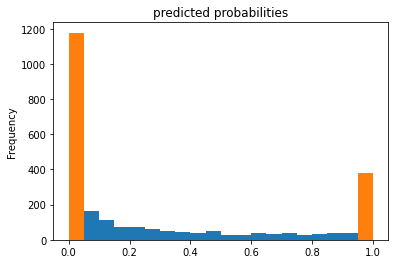

[ *** ] STEP MAX: 800
[ $$$ ] TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting b

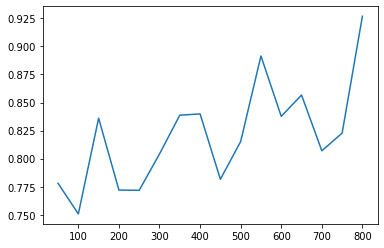

[ $$$ ] TEST
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False t

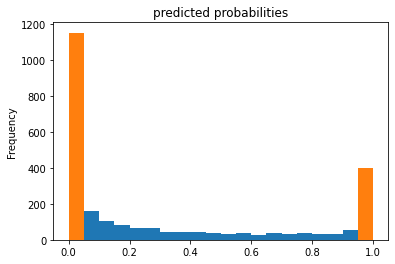

[ *** ] STEP MAX: 850
[ $$$ ] TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting b

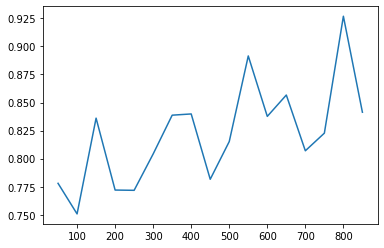

[ $$$ ] TEST
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False t

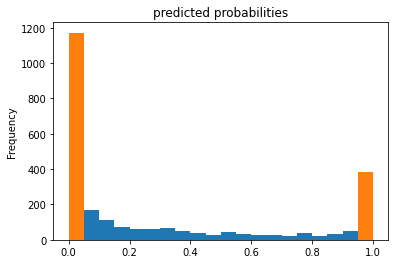

[ *** ] STEP MAX: 900
[ $$$ ] TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting b

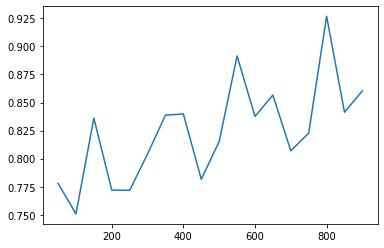

[ $$$ ] TEST
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False t

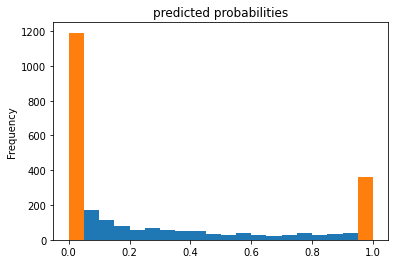

[ *** ] STEP MAX: 950
[ $$$ ] TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting b

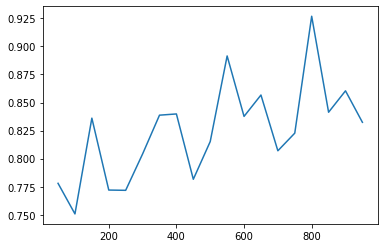

[ $$$ ] TEST
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False t

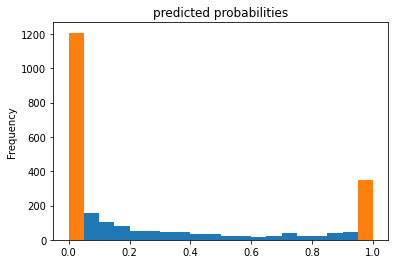

[ *** ] STEP MAX: 1000
[ $$$ ] TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting 

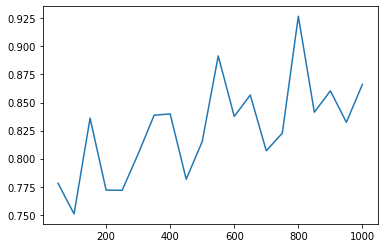

[ $$$ ] TEST
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False t

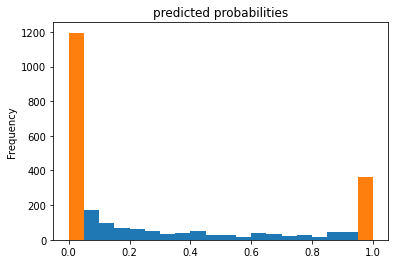

[ *** ] STEP MAX: 1050
[ $$$ ] TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting 

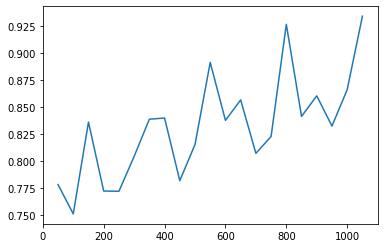

[ $$$ ] TEST
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False t

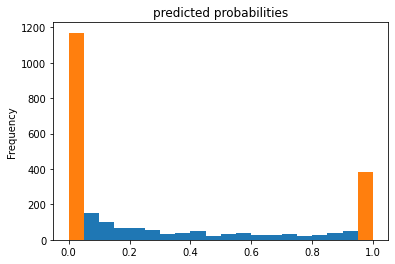

[ *** ] STEP MAX: 1100
[ $$$ ] TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting 

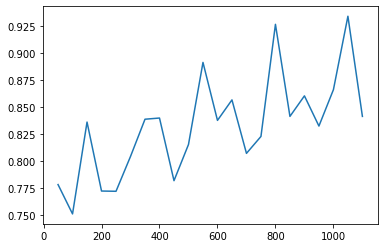

[ $$$ ] TEST
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False t

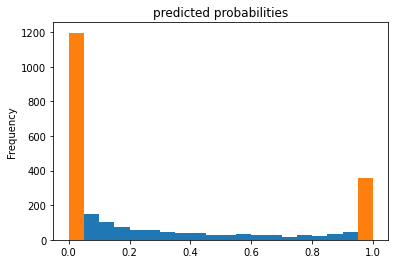

[ *** ] STEP MAX: 1150
[ $$$ ] TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting 

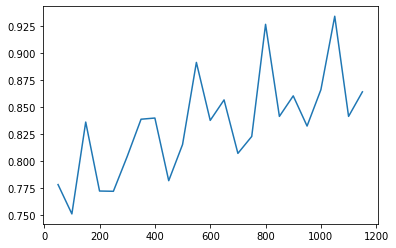

[ $$$ ] TEST
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False t

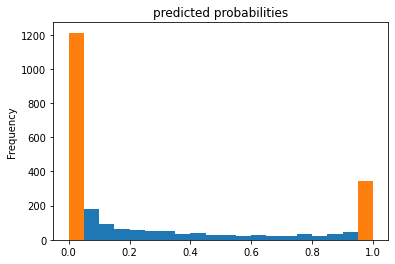

[ *** ] STEP MAX: 1200
[ $$$ ] TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting 

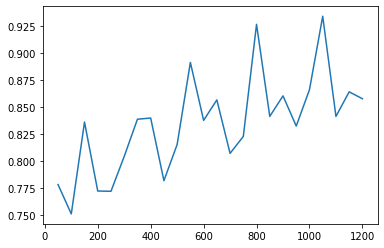

[ $$$ ] TEST
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False t

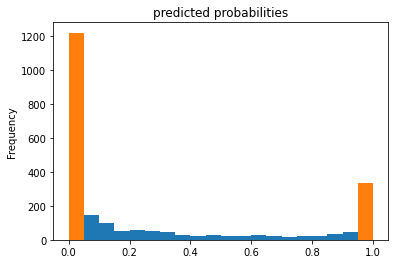

[ *** ] STEP MAX: 1250
[ $$$ ] TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting 

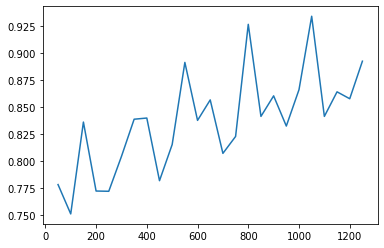

[ $$$ ] TEST
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False t

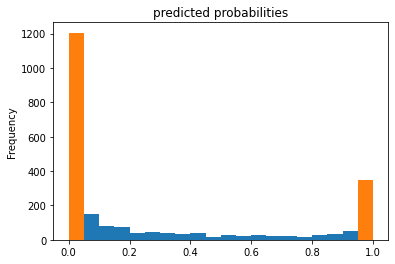

[ *** ] STEP MAX: 1300
[ $$$ ] TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting 

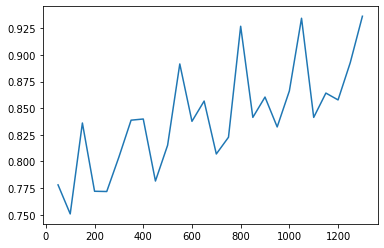

[ $$$ ] TEST
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False t

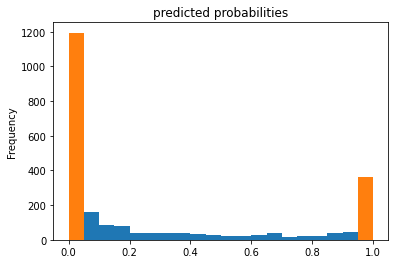

[ *** ] STEP MAX: 1350
[ $$$ ] TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting 

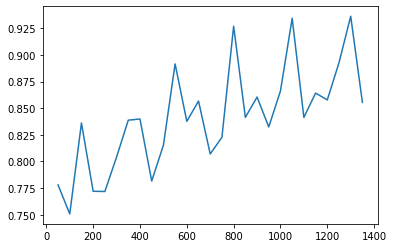

[ $$$ ] TEST
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False t

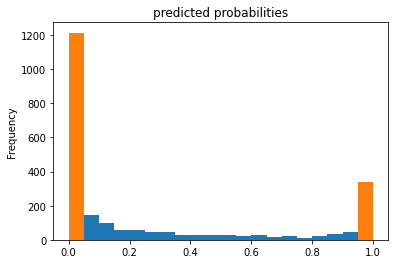

[ *** ] STEP MAX: 1400
[ $$$ ] TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting 

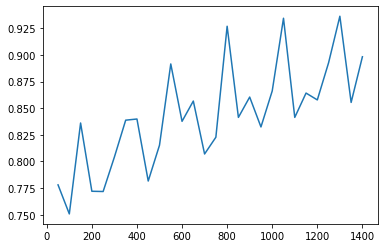

[ $$$ ] TEST
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False t

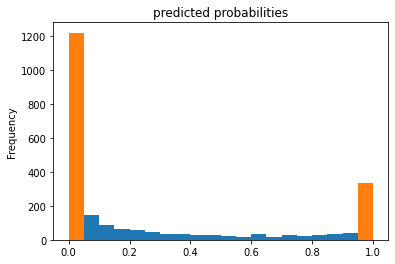

[ *** ] STEP MAX: 1450
[ $$$ ] TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting 

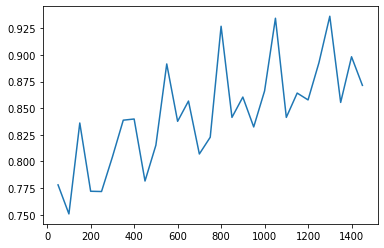

[ $$$ ] TEST
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False t

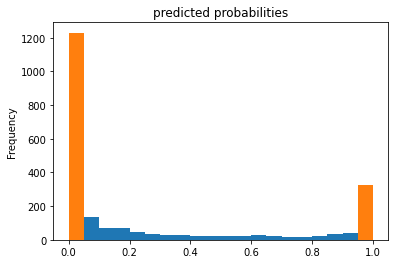

[ *** ] STEP MAX: 1500
[ $$$ ] TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting 

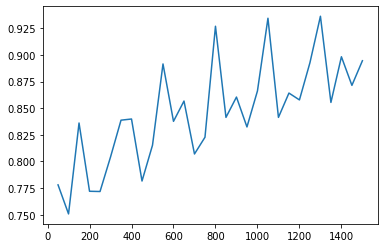

[ $$$ ] TEST
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False t

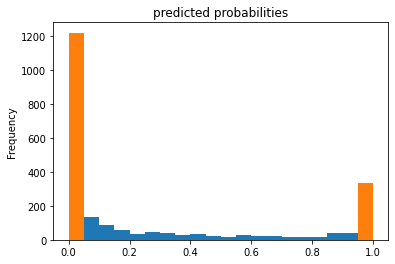

[ *** ] STEP MAX: 1550
[ $$$ ] TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting 

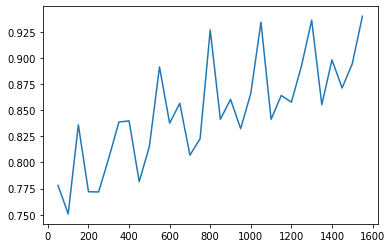

[ $$$ ] TEST
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False t

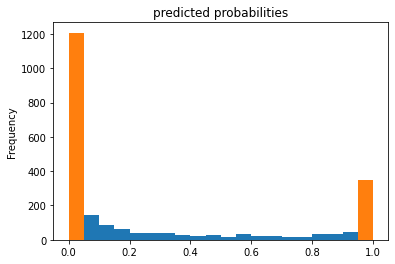

[ *** ] STEP MAX: 1600
[ $$$ ] TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting 

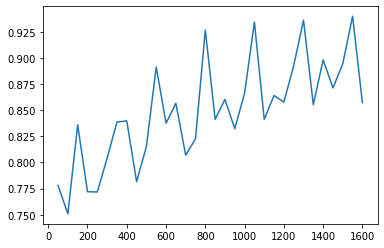

[ $$$ ] TEST
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False t

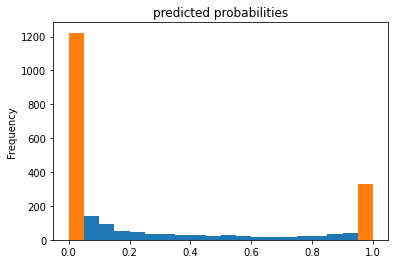

[ *** ] STEP MAX: 1650
[ $$$ ] TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting 

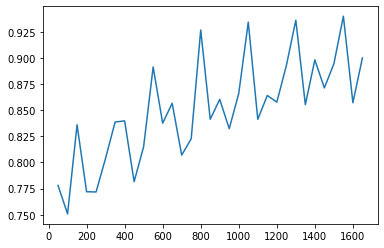

[ $$$ ] TEST
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False t

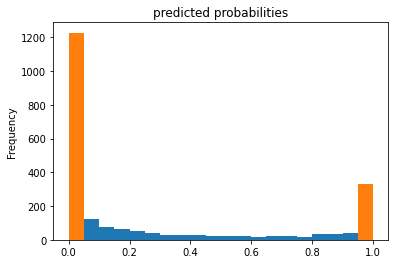

[ *** ] STEP MAX: 1700
[ $$$ ] TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting 

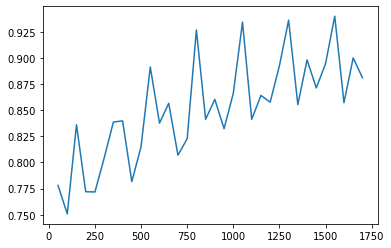

[ $$$ ] TEST
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False t

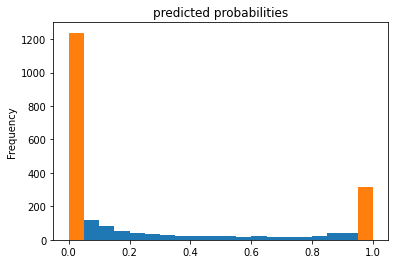

[ *** ] STEP MAX: 1750
[ $$$ ] TRAINING
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting 

KeyboardInterrupt: 

In [19]:
def one_hot_cat_column(feature_name, vocab):
  return tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name,
                                           dtype=tf.float32))
DNN_NUMERIC_COLUMNS = []
DNN_NUMERIC_COLUMNS = ['neigh_vote', 'neigh_swing', 'neigh_pop']
dnn_feature_cols = feature_columns

# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).
    dataset = dataset.repeat(n_epochs)
    # In memory training doesn't use batching.
    dataset = dataset.batch(NUM_EXAMPLES)
    return dataset
  return input_fn

# Training and evaluation input functions.
og_train_input_fn = make_input_fn(train_x, train_y, shuffle=False, n_epochs=1)
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)
test_input_fn = make_input_fn(test_x, None, shuffle=False, n_epochs=1)

# (k-1)/k size MINI BATCHING
trains = []
vals = []
k = 5
splitter = 1555//k
split_index = [splitter*i for i in range(k)]
back_idx = [splitter*(i+1) for i in range(k)]
back_idx[-1] = 1555
yvals = []

print(split_index)
print(back_idx)

train_x1 = train_x
train_y1 = train_y

for i in range(k):
    # dftrain = train_x.iloc[:split,:]
    # y_train = train_y.iloc[:split]
    train_x = train_x1.copy()
    train_y = train_y1.copy()
    tdf = pd.concat([train_x.iloc[:split_index[i],:], train_x.iloc[back_idx[i]:,:]])
    ty = pd.concat([train_y.iloc[:split_index[i]], train_y.iloc[back_idx[i]:]])
    
    df = train_x.iloc[split_index[i]:back_idx[i],:]
    y = train_y.iloc[split_index[i]:back_idx[i]]
    
    print(tdf)
    print(ty)
    print(df)
    print(y)
    trains.append(make_input_fn(tdf, ty, shuffle = True))
    vals.append(make_input_fn(df,y,shuffle=False, n_epochs=1))
    yvals.append(y)

print(trains)
print(vals)
    
# # Since data fits into memory, use entire dataset per layer. It will be faster.
# # Above one batch is defined as the entire dataset.

weight_col = 'Weight'

# DNN??
est = tf.estimator.DNNLinearCombinedClassifier(
    # wide settings
    linear_feature_columns=feature_columns,
    linear_optimizer = 'Adam',
    dnn_optimizer = 'Adam',
    dnn_feature_columns=feature_columns,  
    dnn_activation_fn = tf.nn.relu,
    dnn_hidden_units=[15],
    weight_column = 'Weight',
    dnn_dropout = None,
    batch_norm = False
)

_run = True
n = 0
i = 3
scores = [0 for i in range(k)]

accs = []
ns = []

while _run:
    incr = 50
    n += incr
    
    # EARLY STOPPING
    if n > 100*incr:
        break
    
    # BATCH SELECTOR
    i += 1
    i = i%k
    
    print(f"[ *** ] STEP MAX: {n}")
    
    # Train on Worst Minibatch    
    #     worst = np.argmin(scores)
    #     print(worst)
    #     i = worst
    
    # Train on mini batches    
    train_input_fn = trains[i]
    eval_input_fn  = vals[i]

    # Train on the entire data set
    #     train_input_fn = og_train_input_fn


    print("[ $$$ ] TRAINING")
    # Train up to n steps
    est.train(train_input_fn, max_steps=n)
    
    # Eval.
    print("[ $$$ ] EVAL RESULTS:")
    eval_pred_dicts = list(est.predict(eval_input_fn))
    result = est.evaluate(eval_input_fn)
    print(pd.Series(result))

    eval_preds = pd.Series([pred['probabilities'][1] for pred in eval_pred_dicts])
    
    eval_submission = cthresh(eval_preds, thresh = 0.5)
    try:
        w_acc = weighted_accuracy(eval_submission, yvals[i])
        accs.append(w_acc)
    except:
        w_acc = .69
        
    scores[i] = w_acc
    print("[ $ ] WEIGHTED ACCURACY ON EVAL: ")
    print(w_acc)
    
    # Create a graph over time of 1/k validation accuracy
    print("[ $ ] VALIDATION ACCURACY OVER TIME: ")
    ns.append(n)
    plt.plot(ns,accs)
    plt.show()
    
    # Test and send to submission
    print("[ $$$ ] TEST")
    pred_dicts = list(est.predict(test_input_fn))
    
    preds = None
    preds = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

    # Create histogram of the predictions
    preds.plot(kind='hist', bins=20, title='predicted probabilities')

    submission = cpackage(preds, dfsample.copy(), thresh = 0.5)
    
    # Create a histogram of submission statistics
    submission.iloc[0:,1].plot(kind='hist', bins=20, title='predicted probabilities')
    plt.show()
 
    name = 'creative/submission2_r.csv'
    submission.to_csv(name ,index = False)
    submiss = pd.read_csv(name, sep=',', encoding='unicode_escape')

    _run = w_acc < 1.01

<h3>3.2 Explanation in Words:</h3><p>

You need to answer the following questions in a markdown cell after this cell:

3.2.1 How much did you manage to improve performance on the test set compared to part 2? Did you reach the 75% accuracy for the test in Kaggle? (Please include a screenshot of Kaggle Submission)

3.2.2 Please explain in detail how you achieved this and what you did specifically and why you tried this.

<h2>Part 4: Kaggle Submission</h2><p>
You need to generate a prediction CSV using the following cell from your trained model and submit the direct output of your code to Kaggle. The CSV shall contain TWO column named exactly "FIPS" and "Result" and 1555 total rows excluding the column names, "FIPS" column shall contain FIPS of counties with same order as in the test_2016_no_label.csv while "Result" column shall contain the 0 or 1 prdicaitons for corresponding columns. A sample predication file can be downloaded from Kaggle.

In [ ]:
# TODO

# You may use pandas to generate a dataframe with FIPS and your predictions first 
# and then use to_csv to generate a CSV file.

<h2>Part 5: Resources and Literature Used</h2><p>